# Explore dataset and retrieve URL embeddings

## Explore dataset

In [21]:
import pandas as pd
import matplotlib.pyplot as plt


In [16]:
df = pd.read_csv('phishing_site_urls.csv')
df

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad


In [17]:
duplicate_urls_count = df.duplicated(subset=['URL'], keep=False).sum()
print(duplicate_urls_count)

77074


In [18]:
df.drop_duplicates(subset='URL', keep='first', inplace=True)

In [19]:
df

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
516466,23.227.196.215/,bad
516467,apple-checker.org/,bad
516468,apple-iclods.org/,bad
516469,apple-uptoday.org/,bad


good    392897
bad     114298
Name: Label, dtype: int64


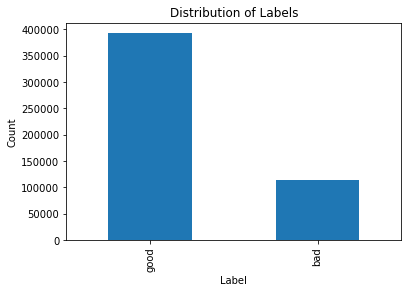

In [20]:
print(df['Label'].value_counts())
df['Label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


## Sample of dataset

In [26]:
good_samples = df[df['Label'] == 'good'].sample(2500, random_state=42)
bad_samples = df[df['Label'] == 'bad'].sample(2500, random_state=42)
df_sample = pd.concat([good_samples, bad_samples])
df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)


## Embed the sample URL's using MiniLM

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2 This is a sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space.

In [27]:
from url_embedding import URLEmbedder
from tqdm import tqdm

tqdm.pandas()
embedder = URLEmbedder()

df_sample['Embeddings'] = df_sample['URL'].progress_apply(embedder.url_to_embedding)


100%|██████████| 5000/5000 [01:12<00:00, 68.70it/s]


In [28]:
df_sample

,URL,Label,Embeddings
0,cbc.ca/sports/indepth/expos/woes.html,good,"[-0.00935816764831543, 0.07413012534379959, -0..."
1,'www.divulgarce.com.br/2011//wp-admin/maint/pr...,bad,"[0.026201924309134483, 8.966281893663108e-05, ..."
2,update.sppen.com/setup/sppen_Setup_silent.exe,bad,"[0.007082153577357531, -0.06453803181648254, -..."
3,ebay.com/itm/1934-Ad-Wrigleys-Double-Mint-Gum-...,good,"[-0.09509860724210739, 0.029595255851745605, -..."
4,guardian.co.uk/film/2009/aug/30/miranda-richar...,good,"[-0.0822666808962822, -0.006449347827583551, -..."
...,...,...,...
4995,ipjacarezinho.org.br/stats/index.php,bad,"[0.053319305181503296, -0.003357160370796919, ..."
4996,armchairgeneral.com/category/carlo-deste,good,"[-0.08177042007446289, -0.0060075330547988415,..."
4997,city-charger.ru/43ftybb8,bad,"[-0.05444147065281868, 0.11203248053789139, -0..."
4998,steelbase.co.kr/wp-content/cache/bookmark/book...,bad,"[-0.07021351158618927, -0.02877296321094036, -..."


In [29]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Drop rows where 'Embeddings' is NaN
df_sample = df_sample.dropna(subset=['Embeddings'])

# Convert embeddings lists to numpy array
X = np.vstack(df_sample['Embeddings'].to_numpy())

# Convert string labels to numerical format
y = df_sample['Label'].map({'good': 1, 'bad': 0}).to_numpy()


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [32]:
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.88      0.83      0.85       524
           1       0.82      0.87      0.85       476

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



In [33]:
from sklearn.metrics import f1_score

# Calculate F1 Score
f1 = f1_score(y_test, predictions, average='weighted')
print('F1 Score:', f1)


F1 Score: 0.8490796000044013


In [34]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)


[[433  91]
 [ 60 416]]


## Embedding the full dataset of URL's using MiniLM

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2 This is a sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space.

In [35]:
from url_embedding import URLEmbedder
from tqdm import tqdm

tqdm.pandas()
embedder = URLEmbedder()

df['Embeddings'] = df['URL'].progress_apply(embedder.url_to_embedding)


100%|██████████| 507195/507195 [1:51:57<00:00, 75.50it/s]   


In [46]:
df

,URL,Label,Embeddings
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[-0.08934366703033447, -0.010603426955640316, ..."
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[-0.07558689266443253, 0.03260812163352966, 0...."
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[-0.03573635593056679, 0.021130207926034927, -..."
3,mail.printakid.com/www.online.americanexpress....,bad,"[-0.05508413538336754, -0.03354843705892563, -..."
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[-0.04461636021733284, 0.004012315534055233, 0..."
...,...,...,...
507190,23.227.196.215/,bad,"[-0.0011708217207342386, -0.018237954005599022..."
507191,apple-checker.org/,bad,"[-0.01951279491186142, -0.03594030812382698, 0..."
507192,apple-iclods.org/,bad,"[-0.046614840626716614, -0.014849048107862473,..."
507193,apple-uptoday.org/,bad,"[-0.043062400072813034, 0.005100815556943417, ..."


In [38]:
has_nans = df['Embeddings'].isnull().any()
print(has_nans)

False


In [ ]:
file_path = 'embeddings.pkl'

# Save the DataFrame to a pickle file
df.to_pickle(file_path)